# Load Qick

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from typing import List, Any
from datetime import datetime

from qick_workspace.tools import system_cfg
from qick_workspace.tools.system_tool import select_config_idx, auto_unit
from qick import *
from qick.pyro import make_proxy
from qick import QickConfig
from qick.asm_v2 import QickSpan, QickSweep1D
import Pyro4

Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION = 4

ns_host = "192.168.10.63"
ns_port = 8888
proxy_name = "myqick"

soc, soccfg = make_proxy(ns_host=ns_host, ns_port=ns_port, proxy_name=proxy_name)
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_100127414b1446cf94bc54217e2af34c@192.168.10.63:43131
QICK running on ZCU216, software version 0.2.371

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc timing clock, DAC tile 0, DAC tile 1, DAC tile 3], [DAC tile 2], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230 on JHC3, or QICK box DAC port 8
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 4096 complex samples (0.427 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230 on JHC4, or QICK box DAC port 9
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 8192 complex samples (0.855 us)
		32-bit DDS, range=9584.

In [33]:
from qick_workspace.tools.YOKOGS200 import YOKOGS200
import pyvisa

rm = pyvisa.ResourceManager()
yoko_connect = "USB0::0x0B21::0x0039::91WB18859::INSTR"
yoko = YOKOGS200(yoko_connect, rm)

yoko.OutputOn()

In [34]:
yoko_value = yoko.GetValue()
yoko_value

{'unit': 'A', 'value': 0.00499}

In [ ]:
sgs = "TCPIP0::192.168.10.89::inst0::INSTR"
from qick_workspace.tools.sgs100a import RohdeSchwarzSGS100A

rm = pyvisa.ResourceManager()
sgs = RohdeSchwarzSGS100A(sgs)
sgs.off()

# Load system configuration

In [4]:
qubit_idx = 0

config = {
    **system_cfg.hw_cfg,
    **system_cfg.readout_cfg,
    **system_cfg.qubit_cfg,
    **system_cfg.expt_cfg,
    **system_cfg.cool_cfg,
}

In [ ]:
from qick_workspace.tools.resonator_tools import circuit
from qick_workspace.scrip.s002_res_spec_ge import Resonator_onetone
from qick_workspace.scrip.s003_qubit_spec_ge import Qubit_Twotone
from qick_workspace.scrip.s005_power_rabi_ge import Amp_Rabi
from qick_workspace.scrip.s006_Ramsey_ge import Ramsey
from qick_workspace.scrip.s007_SpinEcho_ge import SpinEcho
from qick_workspace.scrip.s008_T1_ge import T1

# Test experiment config setting

In [6]:
config["nqz_qubit"] = 2
config["res_gain_ge"][qubit_idx] = 0.2
config["qubit_ch"] = 5
# Resonator One-tone Configuration
START_FREQ = config["res_freq_ge"][qubit_idx] - 10  # [MHz]
STOP_FREQ = config["res_freq_ge"][qubit_idx] + 10  # [MHz]
STEPS = 101

onetone_cfg = select_config_idx(config, qubit_idx)
onetone_cfg.update(
    [
        ("steps", STEPS),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("relax_delay", 1),
        ("cooling", False),
    ]
)

# Qubit Two-tone Configuration
center = 4600
SPAN = 100
START_FREQ = center - SPAN  # [MHz]
STOP_FREQ = center + SPAN  # [MHz]
STEPS = 201
run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixer_freq", center),
        ("qubit_gain_ge", 0.2),
        ("qubit_length_ge", 5),
        ("relax_delay", 1),
    ]
)

# Amp Rabi Configuration
START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100
config["sigma"][qubit_idx] = 0.05
config["relax_delay"] = 50  # [us]
run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_gain_ge", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
    ]
)

# Ramsey Configuration
START_TIME = 0.0  # [us]
STOP_TIME = 5  # [us]
STEPS = 100
run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 2),
    ]
)
# Spin Echo Configuration
START_TIME = 0.0  # [us]
STOP_TIME = 10  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 1),
    ]
)

# T1 Configuration
run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 100  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("relax_delay", 50),
        ("cooling", False),
        ("qubit_ch", 7),
    ]
)

# Auto Experiment

In [ ]:
qubit_idx = 0
pyavg = 50

from qick_workspace.tools import fitting as fitter


def process_fitting(xpts, data, fitfunc):
    data = {
        "xpts": xpts,
        "amps": np.abs(data),
        "phase": np.unwrap(np.angle(data)),
        "avgi": data.real,
        "avgq": data.imag,
    }

    for measure in ("amps", "phase", "avgi", "avgq"):
        popt, pcov, f = fitfunc(data["xpts"], data[measure])
        data[f"fit_{measure}"] = popt
        data[f"fit_err_{measure}"] = pcov

    fit_params, fit_err, best_measure = fitter.get_best_fit(data, fitfunc=None)

    return fit_params, fit_err, best_measure


def fix_phase(p) -> float:
    """
    Normalize phase and calculate pi gain.

    Args:
        p: Parameters list containing phase information

    Returns:
        Pi gain value
    """
    if p[2] > 180:
        p[2] = p[2] - 360
    elif p[2] < -180:
        p[2] = p[2] + 360

    if p[2] < 0:
        pi_gain = (1 / 2 - p[2] / 180) / 2 / p[1]
        pi2_gain = (0 - p[2] / 180) / 2 / p[1]
    else:
        pi_gain = (3 / 2 - p[2] / 180) / 2 / p[1]
        pi2_gain = (1 - p[2] / 180) / 2 / p[1]
    return pi_gain, pi2_gain


class auto:
    def __init__(self, cfg) -> None:
        self.cfg = cfg
        self.cfg["nqz_qubit"] = 2
        self.cfg["res_gain_ge"][qubit_idx] = 0.2
        self.cfg["qubit_ch"] = 5
        self.cfg["sigma"][qubit_idx] = 0.005
        self.report = {}

    def auto_onetone(self):
        # Resonator One-tone Configuration
        START_FREQ = self.cfg["res_freq_ge"][qubit_idx] - 15  # [MHz]
        STOP_FREQ = self.cfg["res_freq_ge"][qubit_idx] + 15  # [MHz]
        STEPS = 101

        onetone_cfg = select_config_idx(self.cfg, qubit_idx)
        onetone_cfg.update(
            [
                ("steps", STEPS),
                ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
                ("relax_delay", 1),
            ]
        )
        res_onetone = Resonator_onetone(soc, soccfg, onetone_cfg)
        res_onetone.auto(py_avg=pyavg)
        ## update value ##

        port = circuit.notch_port()
        port.add_data(res_onetone.freqs, res_onetone.iqdata)
        port.autofit()
        param = port.fitresults
        self.cfg["res_freq_ge"][qubit_idx] = round(param["fr"], 4)
        print(
            "Updated Resonator Frequency: ", self.cfg["res_freq_ge"][qubit_idx], " MHz"
        )
        self.report["resonator_frequency_MHz"] = self.cfg["res_freq_ge"][qubit_idx]
        return res_onetone.freqs, res_onetone.iqdata

    def auto_freq(self, lookup_list):
        yoko.SetCurrent(lookup_list[0])
        print("Set Yoko Current to:", yoko.GetValue())
        self.f_ge_guess = lookup_list[1]

    def auto_twotone(self):
        # Qubit Two-tone Configuration
        center = self.f_ge_guess
        SPAN = 100
        START_FREQ = center - SPAN  # [MHz]
        STOP_FREQ = center + SPAN  # [MHz]
        STEPS = 201
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("qubit_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
                ("qmixer_freq", center),
                ("qubit_gain_ge", 0.2),
                ("qubit_length_ge", 5),
                ("relax_delay", 1),
            ]
        )
        spectrum_ge = Qubit_Twotone(soc, soccfg, run_cfg)
        spectrum_ge.auto(py_avg=pyavg)
        freq, iq = spectrum_ge.freqs, spectrum_ge.iqdata
        pOpt, pCov, fitparams = process_fitting(freq, iq, fitter.fitlor)
        self.cfg["qubit_freq_ge"][qubit_idx] = round(pOpt[2], 6)
        self.cfg["qmixer_freq"][qubit_idx] = round(pOpt[2], 6)
        print("Updated Qubit Frequency: ", self.cfg["qubit_freq_ge"][qubit_idx], " MHz")
        self.report["qubit_frequency_MHz"] = self.cfg["qubit_freq_ge"][qubit_idx]
    def auto_length_rabi(self):
        
    def auto_rabi(self):
        # Amp Rabi Configuration
        START_GAIN = 0.0  # [DAC units]
        STOP_GAIN = 1  # [DAC units]
        STEPS = 100
        self.cfg["relax_delay"] = 50  # [us]

        run_cfg = select_config_idx(self.cfg, qubit_idx)
        current_sigma = self.cfg["sigma"][qubit_idx]
        run_cfg.update(
            [
                ("steps", STEPS),
                ("sigma", current_sigma),
                ("qubit_gain_ge", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
            ]
        )

        prabi = Amp_Rabi(soc, soccfg, run_cfg)
        prabi.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            prabi.gains, prabi.iqdata, fitter.fitdecaysin
        )

        pi_gain, pi2_gain = fix_phase(pOpt)
        self.report["rabi_pi_gain"] = pi_gain
        self.report["rabi_pi2_gain"] = pi2_gain
        self.report["sigma"] = current_sigma
        return pi_gain, pi2_gain

    def auto_rabi_loop(self, max_iterations=5):
        pi_gain = 2.0
        iteration = 0

        while pi_gain > 0.9 and iteration < max_iterations:
            iteration += 1
            current_sigma = self.cfg["sigma"][qubit_idx]
            print(
                f"\n[{iteration}/{max_iterations}] Running Rabi. Current sigma: {current_sigma:.4f}"
            )

            pi_gain, pi2_gain = self.auto_rabi()

            if pi_gain > 0.9:
                old_sigma = self.cfg["sigma"][qubit_idx]
                new_sigma = old_sigma + 0.01

                self.cfg["sigma"][qubit_idx] = round(new_sigma, 4)

                print(
                    f"  ❌ Pi Gain ({pi_gain:.4f}) too high. Sigma -> {new_sigma:.4f}"
                )
            else:
                self.cfg["qubit_pi_gain_ge"][qubit_idx] = pi_gain
                self.cfg["qubit_pi2_gain_ge"][qubit_idx] = pi2_gain

                print(f"  ✅ Pi Gain ({pi_gain:.4f}) OK. Loop finished.")

        if pi_gain > 0.9 and iteration == max_iterations:
            print("\n⚠️ WARNING: Max iterations reached. Pi gain still > 0.9.")

    def auto_ramsey(self, start=None, stop=None):
        if start is None and stop is None:
            START_TIME = 0.0  # [us]
            STOP_TIME = 8  # [us]
        else:
            START_TIME = start
            STOP_TIME = stop
        STEPS = 100
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
                ("ramsey_freq", 2),
            ]
        )
        ramsey = Ramsey(soc, soccfg, run_cfg)
        ramsey.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            ramsey.delay_times, ramsey.iqdata, fitter.fitdecaysin
        )
        self.report["T2_ramsey_us"] = pOpt[3]
        return pOpt

    def auto_finetune_loop(self, max_iterations=3):
        DETUNE_THRESHOLD = 0.005
        iteration = 0
        current_detune = DETUNE_THRESHOLD + 1.0

        print("\n--- Starting Qubit Frequency Fine-Tuning Loop ---")

        while abs(current_detune) > DETUNE_THRESHOLD and iteration < max_iterations:
            iteration += 1
            print(f"[{iteration}/{max_iterations}] Running Ramsey to measure detune...")

            pOpt = self.auto_ramsey(start=0.0, stop=2.0)
            current_detune = pOpt[1] - self.cfg["ramsey_freq"]

            if abs(current_detune) > DETUNE_THRESHOLD:
                adjustment = round(current_detune, 2)

                old_freq = self.cfg["qubit_freq_ge"][qubit_idx]
                new_freq = old_freq - adjustment

                self.cfg["qubit_freq_ge"][qubit_idx] = new_freq

                print(
                    f"Detune: {current_detune:.5f} MHz. Adjusting freq: {old_freq:.5f} MHz -> {new_freq:.5f} MHz"
                )
            else:
                print(
                    f"Detune: {current_detune:.5f} MHz (< {DETUNE_THRESHOLD} MHz). Loop finished."
                )
                break

        if abs(current_detune) > DETUNE_THRESHOLD and iteration == max_iterations:
            print(
                f"\nWARNING: Max iterations reached. Final detune is {current_detune:.5f} MHz."
            )

        return self.cfg["qubit_freq_ge"][qubit_idx]

    def auto_echo(self):
        START_TIME = 0.0  # [us]
        STOP_TIME = 8  # [us]
        STEPS = 100
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
            ]
        )
        echo = SpinEcho(soc, soccfg, run_cfg)
        echo.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            echo.delay_times, echo.iqdata, fitter.fitdecaysin
        )

        print("Updated Qubit T2 Echo: ", round(pOpt[3], 3), " us")
        self.report["T2_echo_us"] = pOpt[3]
        return pOpt

    def auto_t1(self):
        START_TIME = 0.0  # [us]
        STOP_TIME = 100  # [us]
        STEPS = 100
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
            ]
        )

        t1_exp = T1(soc, soccfg, run_cfg)
        t1_exp.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            t1_exp.delay_times, t1_exp.iqdata, fitter.fitexp
        )
        self.report["T1_us"] = pOpt[2]
        print("Updated Qubit T1: ", round(pOpt[2], 3), " us")

    def auto_report(self):
        print("Auto calibration report:")
        print(f"Resonator Frequency {self.report['resonator_frequency_MHz']:.3f} MHz")
        print(f"Qubit Frequency {self.report['qubit_frequency_MHz']:.3f} MHz")
        print(f"Rabi Pi Gain {self.report['rabi_pi_gain']:.3f}")
        print(f"Rabi Pi/2 Gain {self.report['rabi_pi2_gain']:.3f}")
        print(f"Sigma {self.report['sigma']:.3f} us")
        print(f"T2 Ramsey {self.report['T2_ramsey_us']:.3f} us")
        print(f"T2 Echo {self.report['T2_echo_us']:.3f} us")
        print(f"T1 {self.report['T1_us']:.3f} us")

    def dump_report_json(self, filename=None, yokovaue=None):
        if filename is None:
            filename = "auto_report.json"

        root_folder = datetime.now().strftime("%Y%m%d")

        value = yoko.GetValue()
        mode = value["unit"]

        unit_scaled = auto_unit(value["value"])["unit"]
        values_scaled = auto_unit(value["value"])["value"]

        final_report = {
            "timestamp": datetime.now().strftime("%Y-%m-%d-%H:%M:%S"),
            "instrument": {
                "yoko_mode": mode,
                "yoko_unit_scaled": f"{values_scaled:.2f} {unit_scaled}{mode}",
            },
            "calibration_results": self.report.copy(),
        }

        subfolder_name = os.path.splitext(filename)[0]

        if yokovaue is not None:
            filename_base = (
                f"{subfolder_name}_{values_scaled:.2f}_{unit_scaled}{mode}.json"
            )
        else:
            filename_base = filename

        nested_dir = os.path.join(root_folder, subfolder_name)

        if not os.path.exists(nested_dir):
            os.makedirs(nested_dir)

        full_filepath = os.path.join(nested_dir, filename_base)

        with open(full_filepath, "w") as f:
            json.dump(final_report, f, indent=4)

        print(f"Report saved to {full_filepath}")

In [ ]:
def read_qubit_current_sweep_simple(
    filename: str = "qubit_auto_test.json",
) -> List[List[float]]:
    if not os.path.exists(filename):
        print(f"Error: File not found at {filename}")
        return []

    try:
        with open(filename, "r") as f:
            data = json.load(f)

    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {filename}")
        return []

    freq_data = data.get("qubit_freq_vs_current", {})
    if not isinstance(freq_data, dict):
        print("Error: JSON structure 'qubit_freq_vs_current' is not a dictionary.")
        return []

    combined_data = []

    for current_key, freq_value in freq_data.items():
        processed_key = current_key.strip()
        current_A = None

        if processed_key.endswith(" A"):
            try:
                current_A = float(processed_key.replace(" A", ""))
            except ValueError:
                pass

        if current_A is not None and isinstance(freq_value, (int, float)):
            combined_data.append([current_A, freq_value])
        else:
            print(
                f"Warning: Skipping unparsable key/value pair: '{current_key}' -> {freq_value}"
            )

    print(f"Successfully loaded {len(combined_data)} data points from {filename}")
    return combined_data


lookup = read_qubit_current_sweep_simple("qubit_auto_test.json")
print(lookup)

Successfully loaded 16 data points from qubit_auto_test.json
[[-0.0028, 4636.460321], [-0.0025, 4633.081206], [-0.0023, 4625.6479], [-0.0021, 4613.028754], [-0.0019, 4595.701407], [-0.0017, 4573.402983], [-0.0015, 4545.70999], [-0.0013, 4508.630268], [-0.0009, 4392.046501], [-0.0011, 4459.430706], [-0.0004, 4062.185662], [-0.0002, 3837.722], [0.0003, 3103.706826], [0.0005, 2773.592041], [0.0006, 2672.774531], [0.0007, 2547.250881]]


In [41]:
from time import time

start = time()
for lst in lookup:
    print("=== Starting auto calibration for lookup")
    print("Yoko Current set to:", lst[0], "A")
    print("Qubit Frequency guess:", lst[1], "MHz")

    cal = auto(config)
    cal.auto_freq(lookup_list=lst)
    cal.auto_onetone()
    cal.auto_twotone()
    cal.auto_rabi_loop(max_iterations=10)
    cal.auto_finetune_loop(max_iterations=10)
    cal.auto_rabi()
    cal.auto_echo()
    cal.auto_t1()
    cal.auto_report()
    cal.dump_report_json(filename="jpaon.json", yokovaue=yoko.GetValue())
end = time()
print(f"\nTotal auto calibration time: {end - start:.2f} seconds")

Updated Qubit T1:  156.699  us
Auto calibration report:
Resonator Frequency 5350.320 MHz
Qubit Frequency 2604.508 MHz
Rabi Pi Gain 0.013
Rabi Pi/2 Gain 0.008
Sigma 0.005 us
T2 Ramsey 0.552 us
T2 Echo 2.348 us
T1 156.699 us
Report saved to 20251113\jpaon\jpaon_700.00_uA.json

Total auto calibration time: 5924.74 seconds


In [ ]:
from time import time

start = time()
for lst in lookup:
    print("=== Starting auto calibration for lookup")
    print("Yoko Current set to:", lst[0], "A")
    print("Qubit Frequency guess:", lst[1], "MHz")

    cal = auto(config)
    cal.auto_freq(lookup_list=lst)
    cal.auto_onetone()
    cal.auto_twotone()
    cal.auto_rabi_loop(max_iterations=10)
    cal.auto_finetune_loop(max_iterations=10)
    cal.auto_rabi()
    cal.auto_echo()
    cal.auto_t1()
    cal.auto_report()
    cal.dump_report_json(filename="jpaon.json", yokovaue=yoko.GetValue())
end = time()
print(f"\nTotal auto calibration time: {end - start:.2f} seconds")

Updated Qubit T1:  12.096  us
Auto calibration report:
Resonator Frequency 5351.001 MHz
Qubit Frequency 4508.153 MHz
Rabi Pi Gain 0.844
Rabi Pi/2 Gain 0.425
Sigma 0.025 us
T2 Ramsey 2.348 us
T2 Echo 3.493 us
T1 12.096 us
Report saved to 20251112\jpaon.json_-1.30_mA.json

Total auto calibration time: 2629.75 seconds


In [6]:
import json
from typing import List, Dict, Any, Union
from pathlib import Path


def parse_current(current_str: str) -> float:
    """將電流字串（支援 mA 或 uA）轉換為浮點數 mA。"""
    current_str = current_str.strip()

    if current_str.endswith(" mA"):
        return float(current_str.replace(" mA", ""))
    elif current_str.endswith(" uA"):
        return float(current_str.replace(" uA", "")) / 1000
    else:
        raise ValueError(f"Invalid current format: {current_str}")


def read_file_optimized(
    directory_path: Union[str, Path],
) -> List[Dict[str, Union[float, str]]]:
    directory_path = Path(directory_path)

    if not directory_path.is_dir():
        print(f"Error: Directory not found at {directory_path}")
        return []

    all_data_points = []

    # 使用 .glob() 自動查找所有 .json 檔案
    for filepath in directory_path.glob("*.json"):
        try:
            with open(filepath, "r") as f:
                data = json.load(f)

            # --- 提取數據 ---
            results = data.get("calibration_results", {})
            instrument = data.get("instrument", {})

            data_point = {
                "current_mA": parse_current(instrument.get("yoko_unit_scaled", "")),
                "freq_MHz": results["qubit_frequency_MHz"],
                "T1_us": results["T1_us"],
                "T2R_us": results["T2_ramsey_us"],
                "T2E_us": results["T2_echo_us"],
                "source_file": filepath.name,
            }
            all_data_points.append(data_point)

        except json.JSONDecodeError:
            print(f"Warning: Invalid JSON format in {filepath.name}. Skipping.")
        except KeyError as e:
            print(f"Warning: Missing required key {e} in {filepath.name}. Skipping.")
        except ValueError as e:
            print(f"Warning: Error parsing value in {filepath.name}: {e}. Skipping.")
        except Exception as e:
            print(f"Warning: Could not process {filepath.name}: {e}. Skipping.")

    print(
        f"Successfully loaded {len(all_data_points)} total data points from {directory_path}"
    )

    return all_data_points


# --- 執行範例 (假設目錄結構) ---

jpaoff = read_file_optimized(Path("20251112") / "jpaoff")
jpaon = read_file_optimized(Path("20251112") / "jpaon")


Successfully loaded 8 total data points from 20251112\jpaoff
Successfully loaded 8 total data points from 20251112\jpaon


In [ ]:
jpaoff = sorted(jpaoff, key=lambda x: x["current_mA"])
jpaon = sorted(jpaon, key=lambda x: x["current_mA"])


In [14]:
f = {
    "-0.0028 A": 4636.460321,
    "-0.0025 A": 4633.081206,
    "-0.0023 A": 4625.6479,
    "-0.0021 A": 4613.028754,
    "-0.0019 A": 4595.701407,
    "-0.0017 A": 4573.402983,
    "-0.0015 A": 4545.70999,
    "-0.0013 A": 4508.630268,
}
f.values()

dict_values([4636.460321, 4633.081206, 4625.6479, 4613.028754, 4595.701407, 4573.402983, 4545.70999, 4508.630268])

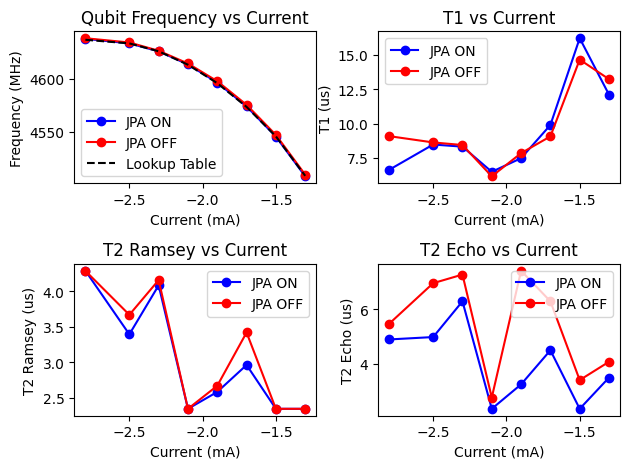

In [28]:
current = []
for i in range(len(jpaon)):
    current.append(jpaon[i].get("current_mA"))
current.sort()

freq = [[] for _ in range(2)]
for i in range(len(jpaon)):
    freq[0].append(jpaon[i].get("freq_MHz"))
    freq[1].append(jpaoff[i].get("freq_MHz"))

t1 = [[] for _ in range(2)]
for i in range(len(jpaon)):
    t1[0].append(jpaon[i].get("T1_us"))
    t1[1].append(jpaoff[i].get("T1_us"))


t2r = [[] for _ in range(2)]
for i in range(len(jpaon)):
    t2r[0].append(jpaon[i].get("T2R_us"))
    t2r[1].append(jpaoff[i].get("T2R_us"))

t2e = [[] for _ in range(2)]
for i in range(len(jpaon)):
    t2e[0].append(jpaon[i].get("T2E_us"))
    t2e[1].append(jpaoff[i].get("T2E_us"))


fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(current, freq[0], "o-", color="b", label="JPA ON")
ax[0, 0].plot(current, freq[1], "o-", color="r", label="JPA OFF")
ax[0, 0].plot(current, list(f.values()), "k--", label="Lookup Table")
ax[0, 0].set_title("Qubit Frequency vs Current")
ax[0, 0].set_xlabel("Current (mA)")
ax[0, 0].set_ylabel("Frequency (MHz)")
ax[0, 0].legend()

ax[0, 1].plot(current, t1[0], "o-", color="b", label="JPA ON")
ax[0, 1].plot(current, t1[1], "o-", color="r", label="JPA OFF")
ax[0, 1].set_title("T1 vs Current")
ax[0, 1].set_xlabel("Current (mA)")
ax[0, 1].set_ylabel("T1 (us)")
ax[0, 1].legend()

ax[1, 0].plot(current, t2r[0], "o-", color="b", label="JPA ON")
ax[1, 0].plot(current, t2r[1], "o-", color="r", label="JPA OFF")
ax[1, 0].set_title("T2 Ramsey vs Current")
ax[1, 0].set_xlabel("Current (mA)")
ax[1, 0].set_ylabel("T2 Ramsey (us)")
ax[1, 0].legend()

ax[1, 1].plot(current, t2e[0], "o-", color="b", label="JPA ON")
ax[1, 1].plot(current, t2e[1], "o-", color="r", label="JPA OFF")
ax[1, 1].set_title("T2 Echo vs Current")
ax[1, 1].set_xlabel("Current (mA)")
ax[1, 1].set_ylabel("T2 Echo (us)")
ax[1, 1].legend()
plt.tight_layout()

In [30]:
f = {
    "-0.0028 A": 4636.460321,
    "-0.0025 A": 4633.081206,
    "-0.0023 A": 4625.6479,
    "-0.0021 A": 4613.028754,
    "-0.0019 A": 4595.701407,
    "-0.0017 A": 4573.402983,
    "-0.0015 A": 4545.70999,
    "-0.0013 A": 4508.630268,
    "-0.0009 A": 4392.046501,
    "-0.0011 A": 4459.430706,
    "-0.0004 A": 4062.185662,
    "-0.0002 A": 3837.722,
    "0.0003 A": 3103.706826,
    "0.0005 A": 2773.592041,
    "0.0006 A": 2672.774531,
    "0.0007 A": 2547.250881,
}
f.values()

dict_values([4636.460321, 4633.081206, 4625.6479, 4613.028754, 4595.701407, 4573.402983, 4545.70999, 4508.630268, 4392.046501, 4459.430706, 4062.185662, 3837.722, 3103.706826, 2773.592041, 2672.774531, 2547.250881])

Successfully loaded 16 total data points from 20251113\jpaon


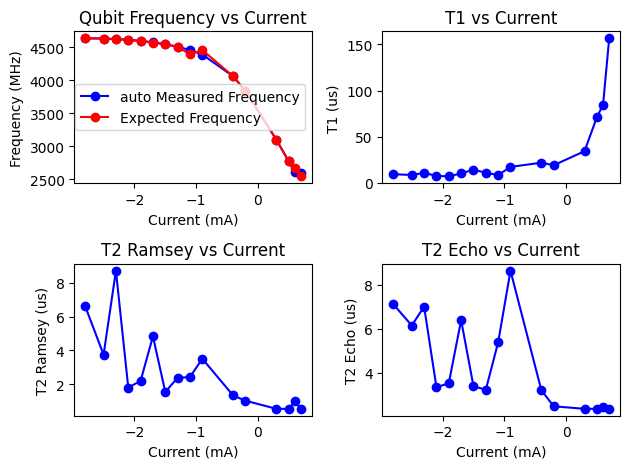

In [31]:
import pandas as pd


jpaon = read_file_optimized(Path("20251113") / "jpaon")
df = pd.DataFrame(jpaon)

df_sorted = df.sort_values(by="current_mA")

current = df_sorted["current_mA"]
freq = df_sorted["freq_MHz"]
t1 = df_sorted["T1_us"]
t2r = df_sorted["T2R_us"]
t2e = df_sorted["T2E_us"]


fig, ax = plt.subplots(2, 2)


ax[0, 0].plot(current, freq, "o-", color="b", label="auto Measured Frequency")
ax[0, 0].plot(current, f.values(), "o-", color="r", label="Expected Frequency")
ax[0, 0].set_title("Qubit Frequency vs Current")
ax[0, 0].set_xlabel("Current (mA)")
ax[0, 0].set_ylabel("Frequency (MHz)")
ax[0, 0].legend()
# Plot 2: T1 vs Current
ax[0, 1].plot(current, t1, "o-", color="b")
ax[0, 1].set_title("T1 vs Current")
ax[0, 1].set_xlabel("Current (mA)")
ax[0, 1].set_ylabel("T1 (us)")

# Plot 3: T2 Ramsey vs Current
ax[1, 0].plot(current, t2r, "o-", color="b")
ax[1, 0].set_title("T2 Ramsey vs Current")
ax[1, 0].set_xlabel("Current (mA)")
ax[1, 0].set_ylabel("T2 Ramsey (us)")

# Plot 4: T2 Echo vs Current
ax[1, 1].plot(current, t2e, "o-", color="b")
ax[1, 1].set_title("T2 Echo vs Current")
ax[1, 1].set_xlabel("Current (mA)")
ax[1, 1].set_ylabel("T2 Echo (us)")

plt.tight_layout()
plt.show()